# TP2

## **Importación de bibliotecas y datasets de entrenamiento y evaluación.**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

import joblib

np.random.seed(0)
tf.random.set_seed(0)

### **Dataset de entrenamiento**

Aclaración: para poder utilizar el dataset de train, lo partimos en 3 para poder subirlo a Github, leerlos, y luego concatenarlos para formar el dataset completo.

In [ ]:
df_train1 = pd.read_csv("https://raw.githubusercontent.com/AlanBotoshansky/7506R-1C2023-GRUPO14/main/TP2/Datasets/train1.csv")
df_train2 = pd.read_csv("https://raw.githubusercontent.com/AlanBotoshansky/7506R-1C2023-GRUPO14/main/TP2/Datasets/train2.csv")
df_train3 = pd.read_csv("https://raw.githubusercontent.com/AlanBotoshansky/7506R-1C2023-GRUPO14/main/TP2/Datasets/train3.csv")

In [ ]:
df_train_default = pd.concat([df_train1, df_train2, df_train3], ignore_index=True)
df_train = df_train_default.copy()
df_train

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,Voy a tener que estar en desacuerdo con el com...,negativo


### **Dataset de evaluación**

Importamos el dataset de test sobre el cual hay que predecir la variable target, "sentimiento".

In [ ]:
df_test_default = pd.read_csv("https://raw.githubusercontent.com/AlanBotoshansky/7506R-1C2023-GRUPO14/main/TP2/Datasets/test.csv")
df_test = df_test_default.copy()
df_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


## **Preprocesamiento y transformación de los datasets**

Le asignamos valores númericos a la variable "sentimiento" del dataframe de entrenamiento, para poder entrenar a nuestros modelos y realizar predicciones. El valor 'positivo' lo reemplazamos por 1 y el valor 'negativo' lo reemplazamos por 0. Una vez realizadas las predicciones, volveremos a reemplazar dichos números por los valores originales, para poder realizar las submissions correctamente en Kaggle.

In [ ]:
df_train = df_train.replace({'sentimiento': {'positivo': 1, 'negativo': 0}})
df_train

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,1
1,1,Una pequeña pequeña producción.La técnica de f...,1
2,2,Pensé que esta era una manera maravillosa de p...,1
3,3,"Básicamente, hay una familia donde un niño peq...",0
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1
...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,1
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",0
49997,49997,Soy católica enseñada en escuelas primarias pa...,0
49998,49998,Voy a tener que estar en desacuerdo con el com...,0


Hacemos una partición (proporción de 80/20) del dataframe de entrenamiento, para poder validar el rendimiento de nuestros modelos luego de entrenarlos.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df_train["review_es"], df_train["sentimiento"], test_size=0.2, random_state=0, stratify=df_train["sentimiento"].values)

Como los modelos predictivos que entrenaremos solo pueden tomar valores numéricos, transformaremos las críticas a vectores numéricos mediante modelos de *bag of words*.

Llevaremos a cabo los modelos utilizando *Pipelines*, de forma que les podremos dar los datos de entrenamiento tal y como vienen, y en una primera etapa el modelo de *bag of words* preprocesa los datos, y luego el modelo predictivo realiza la predicción. Para el caso de las redes neuronales, en vez de utilizar un modelo que vectorice los textos utilizamos una capa de la red.

## **Funciones auxiliares**

In [ ]:
def obtener_f1_score(y_test, y_pred):
  if type(y_pred[0]) == np.ndarray:  #La predicción fue hecha por una red neuronal
    y_pred = np.round(y_pred.flatten()).astype(int)

  return f1_score(y_test, y_pred, average='weighted')

In [ ]:
def imprimir_f1_score(y_test, y_pred):
  print("F1 score:", obtener_f1_score(y_test, y_pred))

In [ ]:
def classification_report_and_confusion_matrix(y_test, y_pred, digits=4):
  if type(y_pred[0]) == np.ndarray:  #La predicción fue hecha por una red neuronal
    y_pred = np.round(y_pred.flatten()).astype(int)

  print(classification_report(y_val, y_pred, digits=digits))

  tabla = confusion_matrix(y_test, y_pred)
  sns.heatmap(tabla, cmap='crest', annot=True, fmt='g')
  plt.xlabel('Predicho')
  plt.ylabel('Real')
  plt.show()

In [ ]:
def descripcion_bayes_naive(bn, f1_score_en_train):
    params = bn.get_params()
    vectorizer = bn.steps[0][1].__class__.__name__
    alpha = params['bn__alpha']
    fit_prior =params['bn__fit_prior']

    return f"BN-vec_{vectorizer}-alpha_{round(alpha, 2)}-fp_{fit_prior}-f1_{round(f1_score_en_train, 4)}"

In [ ]:
def predecir_y_exportar_a_csv_con_bayes_naive(bn, x_test, f1_score_en_train):
    y_pred = bn.predict(x_test)

    df_submission = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': y_pred})
    df_submission = df_submission.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})

    bn_desc = descripcion_bayes_naive(bn, f1_score_en_train)

    df_submission.to_csv(f"pred_{bn_desc}.csv", index=False)

In [ ]:
def exportar_bayes_naive(bn, f1_score_en_train):
    bn_desc = descripcion_bayes_naive(bn, f1_score_en_train)

    joblib.dump(bn, f'{bn_desc}.joblib')

In [ ]:
def descripcion_random_forest(rf, f1_score_en_train):
    params = rf.get_params()
    vectorizer = rf.steps[0][1].__class__.__name__
    criterion = params['rf__criterion']
    n_estimators = params['rf__n_estimators']
    max_features = params['rf__max_features']

    return f"RF-vec_{vectorizer}-crit_{criterion}-n_estim_{n_estimators}-max_f_{max_features}-f1_{round(f1_score_en_train, 4)}"

In [ ]:
def predecir_y_exportar_a_csv_con_random_forest(rf, x_test, f1_score_en_train):
    y_pred = rf.predict(x_test)

    df_submission = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': y_pred})
    df_submission = df_submission.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})

    rf_desc = descripcion_random_forest(rf, f1_score_en_train)

    df_submission.to_csv(f"pred_{rf_desc}.csv", index=False)

In [ ]:
def exportar_random_forest(rf, f1_score_en_train):
    rf_desc = descripcion_random_forest(rf, f1_score_en_train)

    joblib.dump(rf, f'{rf_desc}.joblib')

In [ ]:
def descripcion_xgboost(xgb, f1_score_en_train):
    params = xgb.get_params()
    vectorizer = xgb.steps[0][1].__class__.__name__
    n_estimators = params['xgb__n_estimators']
    max_depth = params['xgb__max_depth']
    learning_rate = params['xgb__learning_rate']
    gamma = params['xgb__gamma']
    reg_alpha = params['xgb__reg_alpha']
    reg_lambda = params['xgb__reg_lambda']

    return f"XGB-vec_{vectorizer}-n_estim_{n_estimators}-max_d_{max_depth}-lr_{learning_rate}-gam_{round(gamma, 1)}-alp_{round(reg_alpha, 1)}-lam_{round(reg_lambda, 1)}-f1_{round(f1_score_en_train, 4)}"

In [ ]:
def predecir_y_exportar_a_csv_con_xgboost(xgb, x_test, f1_score_en_train):
    y_pred = xgb.predict(x_test)

    df_submission = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': y_pred})
    df_submission = df_submission.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})

    xgb_desc = descripcion_xgboost(xgb, f1_score_en_train)

    df_submission.to_csv(f"pred_{xgb_desc}.csv", index=False)

In [ ]:
def exportar_xgboost(xgb, f1_score_en_train):
    xgb_desc = descripcion_xgboost(xgb, f1_score_en_train)

    joblib.dump(xgb, f'{xgb_desc}.joblib')

In [ ]:
def descripcion_neural_network(nn, f1_score_en_train, epochs, batch_size):
    config = nn.get_config()

    vectorizer = config['layers'][1]['config']['output_mode']
    units = config['layers'][2]['config']['units']
    mid_layers = len(config['layers']) - 3  #Restamos la capa de los inputs, y la primera y la última capa
    activation = config['layers'][2]['config']['activation']
    learning_rate = nn.optimizer.learning_rate.numpy()

    return f"NN-vec_{vectorizer}-u_{units}-midl_{mid_layers}-act_{activation}-lr_{learning_rate}-e_{epochs}-bs_{batch_size}-f1_{round(f1_score_en_train, 4)}"

In [ ]:
def predecir_y_exportar_a_csv_con_neural_network(nn, x_test, f1_score_en_train, epochs, batch_size):
    y_pred = nn.predict(x_test)

    y_pred = np.round(y_pred.flatten()).astype(int)

    df_submission = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': y_pred})
    df_submission = df_submission.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})

    nn_desc = descripcion_neural_network(nn, f1_score_en_train, epochs, batch_size)

    df_submission.to_csv(f"pred_{nn_desc}.csv", index=False)

In [ ]:
def exportar_neural_network(nn, f1_score_en_train, epochs, batch_size):
    nn_desc = descripcion_neural_network(nn, f1_score_en_train, epochs, batch_size)

    nn.save(nn_desc, save_format='tf')

In [ ]:
def descripcion_voting(voting_clf, f1_score_en_train):
    params = voting_clf.get_params()
    estimators = params['estimators']
    estimators = '_'.join([estimator[0] for estimator in estimators])
    voting = params['voting']

    return f"voting_clf-estimators_{estimators}-voting_{voting}-f1_{round(f1_score_en_train, 4)}"

In [ ]:
def predecir_y_exportar_a_csv_con_voting(voting_clf, x_test, f1_score_en_train):
    y_pred = voting_clf.predict(x_test)

    df_submission = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': y_pred})
    df_submission = df_submission.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})

    voting_clf_desc = descripcion_voting(voting_clf, f1_score_en_train)

    df_submission.to_csv(f"pred_{voting_clf_desc}.csv", index=False)

In [ ]:
def exportar_voting(voting_clf, f1_score_en_train):
    voting_clf_desc = descripcion_voting(voting_clf, f1_score_en_train)

    joblib.dump(voting_clf, f'{voting_clf_desc}.joblib')

In [ ]:
def descripcion_stacking(stacking_clf, f1_score_en_train):
    params = stacking_clf.get_params()
    estimators = params['estimators']
    estimators = '_'.join([estimator[0] for estimator in estimators])
    final_estimator = type(params['final_estimator']).__name__

    return f"stacking_clf-estimators_{estimators}-f_estim_{final_estimator}-f1_{round(f1_score_en_train, 4)}"

In [ ]:
def predecir_y_exportar_a_csv_con_stacking(stacking_clf, x_test, f1_score_en_train):
    y_pred = stacking_clf.predict(x_test)

    df_submission = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': y_pred})
    df_submission = df_submission.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})

    stacking_clf_desc = descripcion_stacking(stacking_clf, f1_score_en_train)

    df_submission.to_csv(f"pred_{stacking_clf_desc}.csv", index=False)

In [ ]:
def exportar_stacking(stacking_clf, f1_score_en_train):
    stacking_clf_desc = descripcion_stacking(stacking_clf, f1_score_en_train)

    joblib.dump(stacking_clf, f'{stacking_clf_desc}.joblib')

In [ ]:
from keras import backend as K

def _f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

## **Entrenamiento de los modelos**

Para cada modelo, optimizaremos sus hiperparámetros mediante Cross Validation y lo entrenaremos con los mismos, con el fin de obtener la mejor predicción posible. Primero lo haremos con el modelo de Bag of Words "CountVectorizer", y segundo con "TfidfVectorizer"

### **Bayes Naïve**

Creamos un Bayes Naïve por defecto con el objetivo de observar el rendimiento base, y así podemos tener una idea del resultado a mejorar.

In [ ]:
bn_default = Pipeline([('vectorizer', CountVectorizer()), ('bn', MultinomialNB())])

bn_default.fit(x_train, y_train)

y_pred_train = bn_default.predict(x_val)

imprimir_f1_score(y_val, y_pred_train)

F1 score: 0.8411301220281835


A continuación haremos Cross Validation para la optimización de los hiperparámetros de Bayes Naïve.

In [ ]:
##KFOLD CV Grid Search para buscar el mejor clasificador Bayes Naïve (los mejores atributos, hiperparámetros, etc)

#Conjunto de parámetros que queremos usar
params_grid={ 'bn__alpha': np.linspace(0.1, 2, 20),
              'bn__fit_prior': [True, False]
            }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Metrica que queremos optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average='macro')

CountVectorizer

In [ ]:
#Clasificador Bayes Naïve con CountVectorizer
bn_count = Pipeline([('vectorizer', CountVectorizer()), ('bn', MultinomialNB())])

#Grid Search Cross Validation
gridcv = GridSearchCV(estimator=bn_count, param_grid=params_grid, cv=kfoldcv, scoring=scorer_fn)

gridcv.fit(x_train, y_train)
gridcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros del Bayes Naïve con CountVectorizer: {gridcv.best_params_}")
print(f"Mejor F1 Score: {gridcv.best_score_}")

Entrenamos el Bayes Naïve con CountVectorizer con los hiperparámetros hallados.

In [ ]:
bn = Pipeline([('vectorizer', CountVectorizer()), ('bn', MultinomialNB())])
bn.set_params(**gridcv.best_params_)
bn.fit(x_train, y_train)

y_pred_train_bn = bn.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_bn)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_bn)
exportar_bayes_naive(bn, f1_score_en_train)

Observación:
Podemos ver que el modelo obtenido con Grid Search Cross Validation es el mismo que el conseguido con los parámetros que viene por defecto.

TfidfVectorizer

In [ ]:
#Clasificador Bayes Naïve con TfidfVectorizer
bn_tfidf = Pipeline([('vectorizer', TfidfVectorizer()), ('bn', MultinomialNB())])

#Grid Search Cross Validation
gridcv = GridSearchCV(estimator=bn_tfidf, param_grid=params_grid, cv=kfoldcv, scoring=scorer_fn)

gridcv.fit(x_train, y_train)
gridcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros del Bayes Naïve con TfidfVectorizer: {gridcv.best_params_}")
print(f"Mejor F1 Score: {gridcv.best_score_}")

Entrenamos el Bayes Naïve con TfidfVectorizer con los hiperparámetros hallados.

In [ ]:
bn = Pipeline([('vectorizer', TfidfVectorizer()), ('bn', MultinomialNB())])
bn.set_params(**gridcv.best_params_)
bn.fit(x_train, y_train)

y_pred_train_bn = bn.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_bn)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_bn)
exportar_bayes_naive(bn, f1_score_en_train)

### **Random Forest**

Creamos un Random Forest por defecto con el objetivo de observar el rendimiento base, y así podemos tener una idea del resultado a mejorar.

In [ ]:
rf_default = Pipeline([('vectorizer', CountVectorizer()), ('rf', RandomForestClassifier())])

rf_default.fit(x_train, y_train)

y_pred_train = rf_default.predict(x_val)

imprimir_f1_score(y_val, y_pred_train)

F1 score: 0.838999974239996


A continuación haremos Cross Validation para la optimización de los hiperparámetros de Random Forest.

In [ ]:
##KFOLD CV Random Search para buscar el mejor clasificador Random Forest (los mejores atributos, hiperparámetros, etc)

#Numero de iteraciones
n=10

#Conjunto de parámetros que queremos usar
params_grid = { "rf__criterion": ["gini", "entropy"],
                "rf__n_estimators": list(range(100, 201, 10)),
                "rf__max_features": ["sqrt", "log2"]
              }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Metrica que queremos optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average='macro')

CountVectorizer

In [ ]:
#Clasificador Random Forest con CountVectorizer
rf_count = Pipeline([('vectorizer', CountVectorizer()), ('rf', RandomForestClassifier())])

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=rf_count, param_distributions=params_grid, cv=kfoldcv, scoring=scorer_fn, n_iter=n, random_state=0)

randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros del Random Forest con CountVectorizer: {randomcv.best_params_}")
print(f"Mejor F1 Score: {randomcv.best_score_}")

Entrenamos el Random Forest con CountVectorizer con los hiperparámetros hallados.

In [ ]:
rf = Pipeline([('vectorizer', CountVectorizer()), ('rf', RandomForestClassifier())])
rf.set_params(**randomcv.best_params_)
rf.fit(x_train, y_train)

y_pred_train_rf = rf.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_rf)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_rf)
exportar_random_forest(rf, f1_score_en_train)

TfidfVectorizer

In [ ]:
#Clasificador Random Forest con TfidfVectorizer
rf_tfidf = Pipeline([('vectorizer', TfidfVectorizer()), ('rf', RandomForestClassifier())])

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=rf_tfidf, param_distributions=params_grid, cv=kfoldcv, scoring=scorer_fn, n_iter=n, random_state=0)

randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros del Random Forest con TfidfVectorizer: {randomcv.best_params_}")
print(f"Mejor F1 Score: {randomcv.best_score_}")

Entrenamos el Random Forest con TfidfVectorizer con los hiperparámetros hallados.

In [ ]:
rf = Pipeline([('vectorizer', TfidfVectorizer()), ('rf', RandomForestClassifier())])
rf.set_params(**randomcv.best_params_)
rf.fit(x_train, y_train)

y_pred_train_rf = rf.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_rf)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_rf)
exportar_random_forest(rf, f1_score_en_train)

### **XGBoost**

Creamos un XGBoost por defecto con el objetivo de observar el rendimiento base, y así podemos tener una idea del resultado a mejorar.

In [ ]:
xgb_default = Pipeline([('vectorizer', CountVectorizer()), ('xgb', XGBClassifier())])

xgb_default.fit(x_train, y_train)

y_pred_train = xgb_default.predict(x_val)

imprimir_f1_score(y_val, y_pred_train)

F1 score: 0.840517094406356


A continuación haremos Cross Validation para la optimización de los hiperparámetros de XGBoost.

In [ ]:
##KFOLD CV Random Search para buscar el mejor clasificador XGBoost (los mejores atributos, hiperparámetros, etc)

#Numero de iteraciones
n=10

#Conjunto de parámetros que queremos usar
params_grid = { "xgb__n_estimators": list(range(100,201,10)),
                "xgb__max_depth": list(range(5,25)),
                "xgb__learning_rate": np.linspace(0.1,0.5,5),
                "xgb__gamma": np.linspace(0,1,11),
                "xgb__reg_alpha": np.linspace(0,1,11),
                "xgb__reg_lambda": np.linspace(0,1,11),
              }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Metrica que queremos optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average='macro')

CountVectorizer

In [ ]:
#Clasificador XGBoost con CountVectorizer
xgb_count = Pipeline([('vectorizer', CountVectorizer()), ('xgb', XGBClassifier())])

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=xgb_count, param_distributions=params_grid, cv=kfoldcv, scoring=scorer_fn, n_iter=n, random_state=0)

randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros del XGBoost con CountVectorizer: {randomcv.best_params_}")
print(f"Mejor F1 Score: {randomcv.best_score_}")

Entrenamos el XGBoost con CountVectorizer con los hiperparámetros hallados.

In [ ]:
xgb = Pipeline([('vectorizer', CountVectorizer()), ('xgb', XGBClassifier())])
xgb.set_params(**randomcv.best_params_)
xgb.fit(x_train, y_train)

y_pred_train_xgb = xgb.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_xgb)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_xgb)
exportar_xgboost(xgb, f1_score_en_train)

TfidfVectorizer

In [ ]:
#Clasificador XGBoost con TfidfVectorizer
xgb_tfidf = Pipeline([('vectorizer', TfidfVectorizer()), ('xgb', XGBClassifier())])

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=xgb_tfidf, param_distributions=params_grid, cv=kfoldcv, scoring=scorer_fn, n_iter=n, random_state=0)

randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros del XGBoost con TfidfVectorizer: {randomcv.best_params_}")
print(f"Mejor F1 Score: {randomcv.best_score_}")

Entrenamos el XGBoost con TfidfVectorizer con los hiperparámetros hallados.

In [ ]:
xgb = Pipeline([('vectorizer', TfidfVectorizer()), ('xgb', XGBClassifier())])
xgb.set_params(**randomcv.best_params_)
xgb.fit(x_train, y_train)

y_pred_train_xgb = xgb.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_xgb)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_xgb)
exportar_xgboost(xgb, f1_score_en_train)

### **Red Neuronal**

Definimos una función para construir una red neuronal en Keras

In [ ]:
# Función para construir el modelo de red neuronal en Keras
def create_neural_network(units=10, mid_layers=1, activation='relu', learning_rate=0.001, vectorizer='count'):
    nn = keras.Sequential()
    nn.add(tf.keras.Input(shape=(1,), dtype=tf.string))

    # Creamos la capa para la vectorización de los textos
    vectorize_layer = tf.keras.layers.TextVectorization(output_mode=vectorizer)
    vectorize_layer.adapt(x_train)
    nn.add(vectorize_layer)

    for _ in range(mid_layers):
        nn.add(keras.layers.Dense(units=units, activation=activation))
    nn.add(keras.layers.Dense(units=1, activation='sigmoid'))

    nn.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[_f1_score])
    return nn

Creamos una Red Neuronal "por defecto" (con los parámetros que nostros establecimos por defecto) con el objetivo de observar el rendimiento base, y así podemos tener una idea del resultado a mejorar.

In [ ]:
nn_default = create_neural_network()

nn_default.fit(x_train, y_train, epochs=5, batch_size=500, verbose=1)

y_pred_train = nn_default.predict(x_val)

imprimir_f1_score(y_val, y_pred_train)

A continuación haremos Cross Validation para la optimización de los hiperparámetros de la Red Neuronal.

In [ ]:
##KFOLD CV Random Search para buscar la mejor Red Neuronal (los mejores atributos, hiperparámetros, etc)

#Numero de iteraciones
n=10

#Conjunto de parámetros que queremos usar
params_grid = { 'units': range(10, 101),  # Rango de cantidad de neuronas por capa
                'mid_layers': [1, 2, 3],  # Rango de cantidad de capas intermedias
                'activation': ['relu', 'sigmoid', 'tanh'],  # Funciones de activación de capas intermedias
                'learning_rate': np.logspace(-4, -1, num=100),  # Rango de tasa de aprendizaje
                'vectorizer': ['count', 'tf_idf'],  #Forma de vectorizar los datos. Equivalente a CountVectorizer y TfidfVectorizer de sklearn.
                'epochs': range(5, 16),  # Cantidad de épocas
                'batch_size': range(500, 1001, 50)  # Tamaños de lote
              }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Metrica que queremos optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average='macro')

#Red Neuronal
nn = KerasClassifier(build_fn=create_neural_network, verbose=0)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=nn, param_distributions=params_grid, cv=kfoldcv, scoring=scorer_fn, n_iter=n, random_state=0)

randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros de la red neuronal: {randomcv.best_params_}")
print(f"Mejor F1 Score: {randomcv.best_score_}")

Entrenamos la Red Neuronal con los hiperparámetros hallados.

In [ ]:
units = randomcv.best_params_['units']
mid_layers = randomcv.best_params_['mid_layers']
activation = randomcv.best_params_['activation']
learning_rate = randomcv.best_params_['learning_rate']
vectorizer = randomcv.best_params_['vectorizer']
epochs = randomcv.best_params_['epochs']
batch_size = randomcv.best_params_['batch_size']

nn = create_neural_network(units=units, mid_layers=mid_layers, activation=activation, learning_rate=learning_rate, vectorizer=vectorizer)
nn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

y_pred_train_nn = nn.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_nn)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_nn)
exportar_neural_network(nn, f1_score_en_train, epochs, batch_size)

Código para descargar la carpeta correspondiente al modelo:

In [ ]:
from google.colab import files
import shutil

folder_path = f'/content/{descripcion_neural_network(nn, f1_score_en_train, epochs, batch_size)}'
folder_name = descripcion_neural_network(nn, f1_score_en_train, epochs, batch_size)

shutil.make_archive(folder_name, 'zip', folder_path)
files.download(folder_name + '.zip')

### **Ensambles híbridos**

Descargamos la carpeta almacenada en Google Drive que contiene todos los modelos hallados, y asi poder construir los ensambles híbridos.

In [ ]:
import gdown

url = "https://drive.google.com/drive/folders/1h5nIrt6K7nLPynlhlUPdjBJAjWLfQaUP?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

Para dichos ensambles, utilizaremos como estimadores los Bayes Naïve, Random Forest y XGBoost obtenidos. Dejamos de lado las redes neuronales por un tema de compatibilidad entre sklearn y keras.

In [ ]:
ruta_a_bn1 = '/content/sklearn/Bayes Naive/BN-vec_TfidfVectorizer-alpha_0.2-fp_True-f1_0.86/BN-vec_TfidfVectorizer-alpha_0.2-fp_True-f1_0.86.joblib'
bn1 = joblib.load(ruta_a_bn1)

ruta_a_bn2 = '/content/sklearn/Bayes Naive/BN-vec_TfidfVectorizer-alpha_0.3-fp_True-f1_0.8599/BN-vec_TfidfVectorizer-alpha_0.3-fp_True-f1_0.8599.joblib'
bn2 = joblib.load(ruta_a_bn2)

ruta_a_bn3 = '/content/sklearn/Bayes Naive/BN-vec_TfidfVectorizer-alpha_0.4-fp_True-f1_0.8593/BN-vec_TfidfVectorizer-alpha_0.4-fp_True-f1_0.8593.joblib'
bn3 = joblib.load(ruta_a_bn3)

ruta_a_rf1 = '/content/sklearn/Random Forest/RF-vec_CountVectorizer-crit_entropy-n_estim_180-max_f_sqrt-f1_0.8473/RF-vec_CountVectorizer-crit_entropy-n_estim_180-max_f_sqrt-f1_0.8473.joblib'
rf1 = joblib.load(ruta_a_rf1)

ruta_a_rf2 = '/content/sklearn/Random Forest/RF-vec_TfidfVectorizer-crit_entropy-n_estim_180-max_f_sqrt-f1_0.8459/RF-vec_TfidfVectorizer-crit_entropy-n_estim_180-max_f_sqrt-f1_0.8459.joblib'
rf2 = joblib.load(ruta_a_rf2)

ruta_a_rf3 = '/content/sklearn/Random Forest/RF-vec_TfidfVectorizer-crit_entropy-n_estim_150-max_f_sqrt-f1_0.8418/RF-vec_TfidfVectorizer-crit_entropy-n_estim_150-max_f_sqrt-f1_0.8418.joblib'
rf3 = joblib.load(ruta_a_rf3)

ruta_a_xgb1 = '/content/sklearn/XGBoost/XGB-vec_CountVectorizer-n_estim_130-max_d_21-lr_0.2-gam_0.8-alp_0.4-lam_1.0-f1_0.8498/XGB-vec_CountVectorizer-n_estim_130-max_d_21-lr_0.2-gam_0.8-alp_0.4-lam_1.0-f1_0.8498.joblib'
xgb1 = joblib.load(ruta_a_xgb1)

ruta_a_xgb2 = '/content/sklearn/XGBoost/XGB-vec_TfidfVectorizer-n_estim_170-max_d_14-lr_0.5-gam_0.1-alp_0.5-lam_1.0-f1_0.8429/XGB-vec_TfidfVectorizer-n_estim_170-max_d_14-lr_0.5-gam_0.1-alp_0.5-lam_1.0-f1_0.8429.joblib'
xgb2 = joblib.load(ruta_a_xgb2)

ruta_a_xgb3 = '/content/sklearn/XGBoost/XGB-vec_TfidfVectorizer-n_estim_160-max_d_13-lr_0.4-gam_0.0-alp_0.8-lam_1.0-f1_0.8428/XGB-vec_TfidfVectorizer-n_estim_160-max_d_13-lr_0.4-gam_0.0-alp_0.8-lam_1.0-f1_0.8428.joblib'
xgb3 = joblib.load(ruta_a_xgb3)

Haremos Cross Validation para la optimización de los hiperparámetros de ambos ensambles híbridos. La cantidad de estimadores que utilizaremos para cada uno es 3, por lo que haremos todas las combinaciones posibles de a 3 de los 9 modelos importados (84 combinaciones en total).

In [ ]:
from itertools import combinations

In [ ]:
total_estimators = [('bn1', bn1),('bn2', bn2),('bn3', bn3),('rf1', rf1),('rf2', rf2),('rf3', rf3),('xgb1', xgb1),('xgb2', xgb2),('xgb3', xgb3)]
n_estimators = 3

estimators = list(combinations(total_estimators, n_estimators))
estimators = [list(e) for e in estimators]

#### Voting

Optimizamos sus hiperparámetros mediante K-Fold
Cross Validation.

In [ ]:
##KFOLD CV Random Search para buscar el mejor clasificador VotingClassifier (los mejores atributos, hiperparámetros, etc)

#Numero de iteraciones
n=10

#Conjunto de parámetros que queremos usar
params_grid = { "estimators": estimators,
                "voting": ['hard', 'soft']
              }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador VotingClassifier
voting_clf = VotingClassifier(estimators=[])

#Metrica que queremos optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average='macro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=voting_clf, param_distributions=params_grid, cv=kfoldcv, scoring=scorer_fn, n_iter=n, random_state=0)

randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros del VotingClassifier: {randomcv.best_params_}")
print(f"Mejor F1 Score: {randomcv.best_score_}")

Entrenamos el Voting con los hiperparámetros hallados.

In [ ]:
voting_clf = VotingClassifier(**randomcv.best_params_)
voting_clf.fit(x_train, y_train)

y_pred_train_voting = voting_clf.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_voting)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_voting)
exportar_voting(voting_clf, f1_score_en_train)

#### Stacking

Optimizamos sus hiperparámetros mediante K-Fold
Cross Validation.

In [ ]:
##KFOLD CV Random Search para buscar el mejor clasificador StackingClassifier (los mejores atributos, hiperparámetros, etc)

#Numero de iteraciones
n=10

#Conjunto de parámetros que queremos usar
params_grid = { "estimators": estimators }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador StackingClassifier
stacking_clf = StackingClassifier(estimators=[], final_estimator=XGBClassifier(objective="binary:logistic", random_state=0))

#Metrica que queremos optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average='macro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=stacking_clf, param_distributions=params_grid, cv=kfoldcv, scoring=scorer_fn, n_iter=n, random_state=0)

randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

In [ ]:
print(f"Mejores hiperparámetros del StackingClassifier: {randomcv.best_params_}")
print(f"Mejor F1 Score: {randomcv.best_score_}")

Entrenamos el Stacking con los hiperparámetros hallados.

In [ ]:
stacking_clf = StackingClassifier(**randomcv.best_params_, final_estimator=XGBClassifier(objective="binary:logistic", random_state=0))
stacking_clf.fit(x_train, y_train)

y_pred_train_stacking = stacking_clf.predict(x_val)

imprimir_f1_score(y_val, y_pred_train_stacking)

Exportamos el modelo

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_stacking)
exportar_stacking(stacking_clf, f1_score_en_train)

## **Evaluación de performance**

Importamos los modelos con mejor performance (de acuerdo a la validación) encontrados con Cross Validation.

In [ ]:
ruta_a_bn = '/content/sklearn/Bayes Naive/BN-vec_TfidfVectorizer-alpha_0.2-fp_True-f1_0.86/BN-vec_TfidfVectorizer-alpha_0.2-fp_True-f1_0.86.joblib'
bn = joblib.load(ruta_a_bn)

ruta_a_rf = '/content/sklearn/Random Forest/RF-vec_CountVectorizer-crit_entropy-n_estim_180-max_f_sqrt-f1_0.8473/RF-vec_CountVectorizer-crit_entropy-n_estim_180-max_f_sqrt-f1_0.8473.joblib'
rf = joblib.load(ruta_a_rf)

ruta_a_xgb = '/content/sklearn/XGBoost/XGB-vec_CountVectorizer-n_estim_130-max_d_21-lr_0.2-gam_0.8-alp_0.4-lam_1.0-f1_0.8498/XGB-vec_CountVectorizer-n_estim_130-max_d_21-lr_0.2-gam_0.8-alp_0.4-lam_1.0-f1_0.8498.joblib'
xgb = joblib.load(ruta_a_xgb)


url_nn = "https://drive.google.com/drive/folders/1r3hwVEt-nL650YVlIiOGh66s1n3v06x4?usp=sharing"
gdown.download_folder(url_nn, quiet=True, use_cookies=False)
ruta_a_nn = '/content/NN-vec_count-u_10-midl_1-act_relu-lr_0.001-kr_None-e_5-bs_500-f1_0.8951/NN-vec_count-u_10-midl_1-act_relu-lr_0.001-kr_None-e_5-bs_500-f1_0.8951'
nn = tf.keras.models.load_model(ruta_a_nn, custom_objects={'_f1_score': _f1_score})

ruta_a_voting_clf = '/content/sklearn/Voting/voting_clf-estimators_bn3_xgb1_xgb2-voting_soft-f1_0.868/voting_clf-estimators_bn3_xgb1_xgb2-voting_soft-f1_0.868.joblib'
voting_clf = joblib.load(ruta_a_voting_clf)

ruta_a_stacking_clf = '/content/sklearn/Stacking/stacking_clf-estimators_bn1_rf1_xgb1-f_estim_XGBClassifier-f1_0.8818/stacking_clf-estimators_bn1_rf1_xgb1-f_estim_XGBClassifier-f1_0.8818.joblib'
stacking_clf = joblib.load(ruta_a_stacking_clf)

A continuación observamos las matrices de confusión de los mejores modelos entrenados de cada tipo y vemos que la red neuronal fue la que obtuvo mejores resultados.

#### Bayes Naïve

              precision    recall  f1-score   support

           0     0.8599    0.8602    0.8600      5000
           1     0.8601    0.8598    0.8600      5000

    accuracy                         0.8600     10000
   macro avg     0.8600    0.8600    0.8600     10000
weighted avg     0.8600    0.8600    0.8600     10000



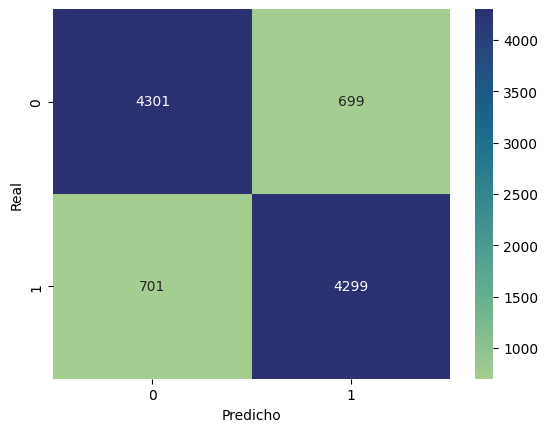

In [ ]:
y_pred_train_bn = bn.predict(x_val)
classification_report_and_confusion_matrix(y_val, y_pred_train_bn)

#### Random Forest

              precision    recall  f1-score   support

           0     0.8517    0.8410    0.8463      5000
           1     0.8430    0.8536    0.8483      5000

    accuracy                         0.8473     10000
   macro avg     0.8474    0.8473    0.8473     10000
weighted avg     0.8474    0.8473    0.8473     10000



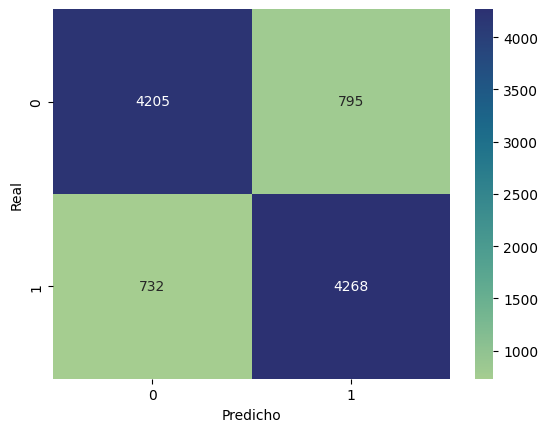

In [ ]:
y_pred_train_rf = rf.predict(x_val)
classification_report_and_confusion_matrix(y_val, y_pred_train_rf)

#### XGBoost

              precision    recall  f1-score   support

           0     0.8580    0.8384    0.8481      5000
           1     0.8420    0.8612    0.8515      5000

    accuracy                         0.8498     10000
   macro avg     0.8500    0.8498    0.8498     10000
weighted avg     0.8500    0.8498    0.8498     10000



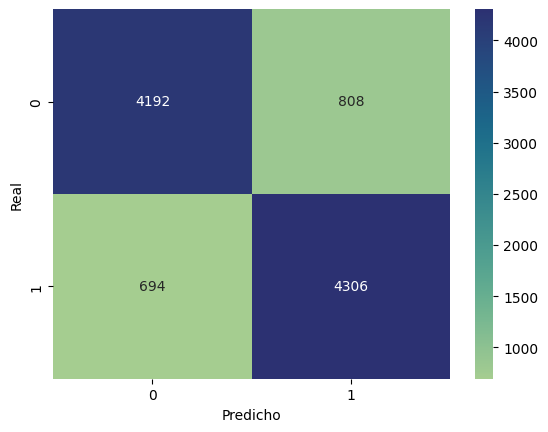

In [ ]:
y_pred_train_xgb = xgb.predict(x_val)
classification_report_and_confusion_matrix(y_val, y_pred_train_xgb)

#### Neural Network

313/313 [==============================] - 11s 34ms/step
              precision    recall  f1-score   support

           0     0.9057    0.8820    0.8937      5000
           1     0.8850    0.9082    0.8965      5000

    accuracy                         0.8951     10000
   macro avg     0.8954    0.8951    0.8951     10000
weighted avg     0.8954    0.8951    0.8951     10000



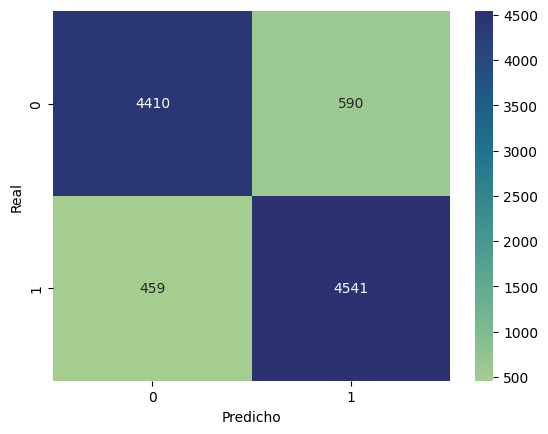

In [ ]:
y_pred_train_nn = nn.predict(x_val)
classification_report_and_confusion_matrix(y_val, y_pred_train_nn)

#### Voting

              precision    recall  f1-score   support

           0     0.8764    0.8568    0.8665      5000
           1     0.8599    0.8792    0.8695      5000

    accuracy                         0.8680     10000
   macro avg     0.8682    0.8680    0.8680     10000
weighted avg     0.8682    0.8680    0.8680     10000



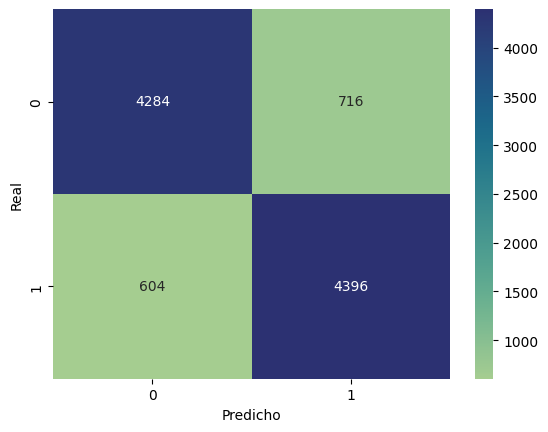

In [ ]:
y_pred_train_voting = voting_clf.predict(x_val)
classification_report_and_confusion_matrix(y_val, y_pred_train_voting)

#### Stacking

              precision    recall  f1-score   support

           0     0.8838    0.8792    0.8815      5000
           1     0.8798    0.8844    0.8821      5000

    accuracy                         0.8818     10000
   macro avg     0.8818    0.8818    0.8818     10000
weighted avg     0.8818    0.8818    0.8818     10000



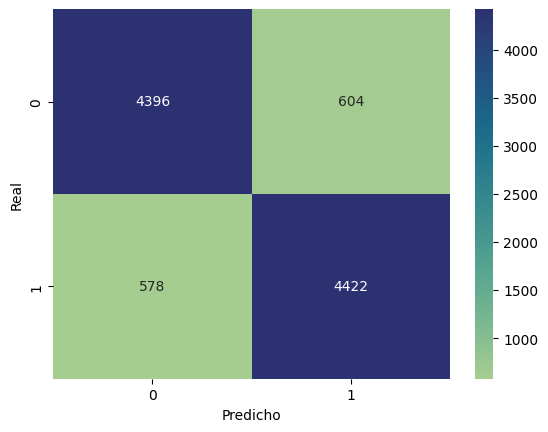

In [ ]:
y_pred_train_stacking = stacking_clf.predict(x_val)
classification_report_and_confusion_matrix(y_val, y_pred_train_stacking)

## **Generación de predicciones**

#### Bayes Naïve

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_bn)
predecir_y_exportar_a_csv_con_bayes_naive(bn, df_test['review_es'], f1_score_en_train)

#### Random Forest

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_rf)
predecir_y_exportar_a_csv_con_random_forest(rf, df_test['review_es'], f1_score_en_train)

#### XGBoost

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_xgb)
predecir_y_exportar_a_csv_con_xgboost(xgb, df_test['review_es'], f1_score_en_train)

#### Neural Network

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_nn)
predecir_y_exportar_a_csv_con_neural_network(nn, df_test['review_es'], f1_score_en_train)

#### Voting

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_voting)
predecir_y_exportar_a_csv_con_voting(voting_clf, df_test['review_es'], f1_score_en_train)

#### Stacking

In [ ]:
f1_score_en_train = obtener_f1_score(y_val, y_pred_train_stacking)
predecir_y_exportar_a_csv_con_stacking(stacking_clf, df_test['review_es'], f1_score_en_train)